Install dependencies

In [25]:
!pip install pyei
!pip install "pymc==5.10.3"

  Using cached pymc-4.0.0b5-py3-none-any.whl (549 kB)
  Attempting uninstall: pymc
    Found existing installation: pymc 5.10.3
    Uninstalling pymc-5.10.3:
      Successfully uninstalled pymc-5.10.3



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Imports

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import json
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from scipy.stats import gaussian_kde



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Work\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Work\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Upload files

In [23]:
import io
election_dataframe = pd.read_csv('ecological_inference_data_white.csv')

In [24]:
# Replace with the column names in your data that give the percentages of demographic groups of interest
# These fractions must sum to 1 within each precinct.
group_fractions_rbyc = np.array(election_dataframe[['Percentage Minority Vote', 'Percentage Non-Minority Vote']]).T

# Replace with the column names in your data that give the votes for candidates of interest
# These fractions  must sum to 1 within each precinct.
# Make sure to use to correct denominator - it should match what you use for precinct_pops below
votes_fractions_rbyc = np.array(election_dataframe[['Percentage Kemp', 'Percentage Hazel', 'Percentage Abrams']]).T

# replace 'total2' with the column name for the total count of votes in your data
# this should be equal to the sum of the counts of votes for the candidates of interest above!
precinct_pops = np.array(election_dataframe['Total Votes']).astype(int)

In [25]:
candidate_names_rbyc = ["Kemp", "Hazel", "Abrams"]
demographic_group_names_rbyc = ["White", "Other"]
precinct_names = election_dataframe['Precinct']

In [ ]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet')

# Fit the model
ei_rbyc.fit(group_fractions_rbyc,
       votes_fractions_rbyc,
       precinct_pops,
       demographic_group_names=demographic_group_names_rbyc,
       candidate_names=candidate_names_rbyc,
       precinct_names=precinct_names, # remove this line if you do not have precinct names or do not need to use them
       chains=4
)

# Generate a simple report to summarize the results
print(ei_rbyc.summary())

Compiling...


Running ['White', 'Other'] x ['Kemp', 'Hazel', 'Abrams'] EI
r = 2 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 2690


Compilation time = 0:00:01.131042
Sampling...
warmup:  34%|████████▉                 | 857/2500 [19:12<37:57,  1.39s/it, 1023 steps of size 1.01e-03. acc. prob=0.98]

array([<Axes: title={'center': 'Support among White'}>,
       <Axes: title={'center': 'Support among Other'}>], dtype=object)

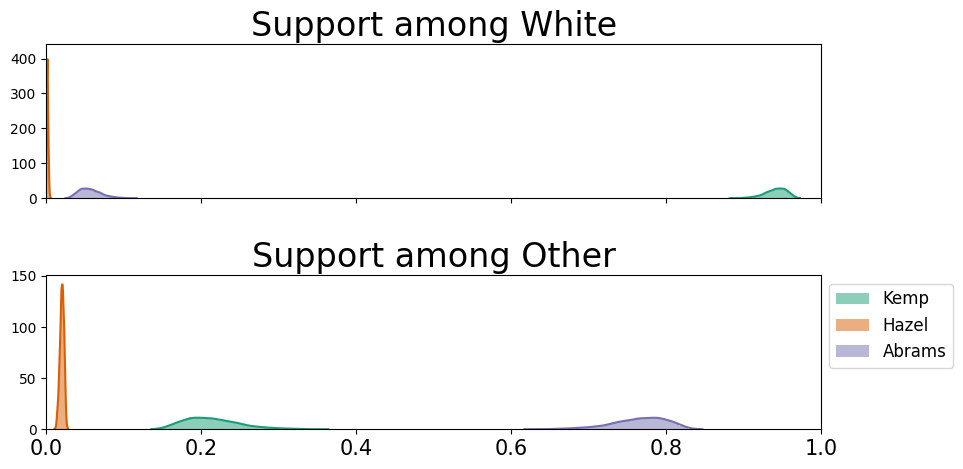

In [20]:
ei_rbyc.plot_kdes(plot_by="group")

In [5]:
def extract_kde_data(sampled_voting_prefs, group_names, candidate_names, plot_by="candidate"):
    _, num_groups, num_candidates = sampled_voting_prefs.shape
    x_values = np.linspace(0, 1, 100)  # Define the range of support values
    data = {}
    if plot_by == "candidate":
        for i in range(num_candidates):
            candidate_data = []
            for j in range(num_groups):
                kde = gaussian_kde(sampled_voting_prefs[:, j, i])
                y_values = kde(x_values)
                candidate_data.append({
                    'group': group_names[j],
                    'x': x_values.tolist(),
                    'y': y_values.tolist()
                })
            data[candidate_names[i]] = candidate_data
    elif plot_by == "group":
        for i in range(num_groups):
            group_data = []
            for j in range(num_candidates):
                kde = gaussian_kde(sampled_voting_prefs[:, i, j])
                y_values = kde(x_values)
                group_data.append({
                    'candidate': candidate_names[j],
                    'x': x_values.tolist(),
                    'y': y_values.tolist()
                })
            data[group_names[i]] = group_data
    else:
        raise ValueError("plot_by must be 'group' or 'candidate'")

    return data

In [21]:
import json
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
_, num_groups, num_candidates = sampled_voting_prefs.shape
data = extract_kde_data(sampled_voting_prefs, demographic_group_names_rbyc, candidate_names_rbyc, "group")
with open('GAGroupWhiteDataSimplified.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

3
2
